# Linear vs nonlinear dimension reduction

We work with a classic dataset on mail messages atttributed to different topics.
The sample has 11314 messages, each message corresponds to one and only one topic.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from time import time
import pandas as pd

% matplotlib inline

In [0]:
from sklearn.manifold import TSNE
import scipy.sparse as sparse

# 1. Download data for learning

## Download data 20newsgroup

The dataset 20newsgroup is available in ```sklearn```.

The data is in  __sklearn.datasets__.

In [0]:
import sklearn.datasets

But we already downloaded to the folder 'data'. So we specify the folder in the dataloader.

In [4]:
newsgroups_training = sklearn.datasets.fetch_20newsgroups(subset='train', data_home='data')

Let's take a look at the data.

In [5]:
print(newsgroups_training.target_names)
print('Number of groups: %d' % len(list(newsgroups_training.target_names)))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Number of groups: 20


There a lot of information about dataset in general and about various objects in the dataset.

In [6]:
newsgroups_training.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

E.g. we have filenames associated with each message

In [7]:
newsgroups_training['filenames']

array(['data/20news_home/20news-bydate-train/rec.autos/102994',
       'data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51861',
       'data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51879',
       ...,
       'data/20news_home/20news-bydate-train/comp.sys.ibm.pc.hardware/60695',
       'data/20news_home/20news-bydate-train/comp.graphics/38319',
       'data/20news_home/20news-bydate-train/rec.motorcycles/104440'],
      dtype='<U67')

Let's see an example of a message.
__index__ corresponds to the number of a message.

Note, that later we work with this problem in a toy mode and don't bother about stopwords, redudant information like mail adresses and so on.

In [8]:
# an example of a message
index = 300
print('Message class:')
print(newsgroups_training['target_names'][newsgroups_training['target'][index]])
print('')
print('Message:')
print(newsgroups_training['data'][index])


Message class:
rec.sport.hockey

Message:
From: jae2001@andy.bgsu.edu (Jason Ehas)
Subject: Re: Giveaways
Organization: Home of 1984 NCAA hockey champs
Lines: 43

In article <1qi44l$kqr@access.digex.net>, steveg@cadkey.com (Steve
Gallichio) wrote:
> 
> 
> John P. Curcio (jpc@philabs.philips.com) responded to my drivel:
> 
> >steveg@cadkey.com (Steve Gallichio) writes:
> > 
> >>I still am surprised that no one has tried giving away the goodies at the end
> >>of the game. The two problems with that, of course, are that you would want
> >>to make sure the first people in the building would be assured of getting
> >>them (probably redeemable vouchers), and that the building managers want to
> >>avoid at all costs delaying people as they leave the building, if, for
> >>instance, the goodies are given to people as they exit.
> >
> >I went to the New Jersey Devils/Carvel Ice Cream Puck Night (tm) last year to
> >see the beloved Bruins play.  The pucks were given out at the end of the game.
> 

# 2. Preprocess data before classifier learning

# 2.1 Very short intro into "classic" text processing

We need some numerical features to use common classifier like xgboost.

## Bag of words

The common assumption is that order of words doesn't matter. 
We need just an indicator if word is here or not and how many particular words are in the given document.

Now and later we'll mostly work with sparse matrices, as we need a separate column for each word for this type of words representation. 

Let's start with only two sentences.

In [0]:
first_sentence = 'Two broad families are analytics-enabled jobs and data science jobs'
second_sentence = 'Happy families are all alike'

data_sentences = [first_sentence, second_sentence]

The most naive version to produced a representation is __CountVectorizer()__.
It provides number of occurences for each word in the text.
Later we'll replace it with __TfidfVectorizer()__.

Both these classes are in NLP-related part of sklearn.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

We start with CountVectorizer()

In [0]:
count_vectorizer = CountVectorizer()

We run it with our example.

In [0]:
result = count_vectorizer.fit_transform(raw_documents=data_sentences)

Let's look at the result of our vectorizer for our example.

Recall, that
* first_sentence = 'Two broad families are analytics-enabled jobs and data science jobs'
* second_sentence = 'Happy families are all alike'

In [13]:
words_dataframe = pd.DataFrame(result.todense(), index=[1, 2], columns=count_vectorizer.get_feature_names())
words_dataframe

,alike,all,analytics,and,are,broad,data,enabled,families,happy,jobs,science,two
1,0,0,1,1,1,1,1,1,1,0,2,1,1
2,1,1,0,0,1,0,0,0,1,1,0,0,0


We have common words for both sentences.
Some words are only in one sentence.
Some words occur multiple times e.g. the word **jobs**.

## Definition of TF-IDF
We adjust our count model to get TF-IDF(term frequency - inverse document frequency).
It has the following assumptions:
* Order of words doesn't matter
* What words are in a document and number of those words in the document are what matter
* More frequent words are more important
* **If words occurs in one document and is rate among other documents, then it is important. The inverse is also important: if some words are in most of the documents, then they are not important for extraction of specific features of a text**

To define TF-IDF we need:
* TF - term frequency 
* IDF - inverse document frequency
* TF-IDF - TF multiplied by IDF


$$  
    TF(w,T)=n_{Tw}, \\ 
    IDF(w, T)= log{\frac{N}{n_{w}}}, \\
    TF\text{-}IDF(w, T) = n_{Tw}\ log{\frac{N}{n_{w}}},
$$
where
* $T$ - a document, 
* $w$ - a word in a document $T$, 
* $n_{Tw}$ - number of occurences of word $w$ in the document $T$, 
* $n_{w}$ - number of documents that contain the word $w$, 
* $N$ - total number of documents in a corpus.

Our matrix of features is sparse.

Let's try TF-IDF vectorizer **TfidfVectorizer()**

In [0]:
tf_idf_vectorizer = TfidfVectorizer()

We start with application of this vectorizer to our examle.

In [0]:
tf_idf_result = tf_idf_vectorizer.fit_transform(raw_documents=data_sentences)

In [16]:
tf_idf_words_dataframe = pd.DataFrame(tf_idf_result.todense(), columns=tf_idf_vectorizer.get_feature_names(), index=[1, 2])
tf_idf_words_dataframe

,alike,all,analytics,and,are,broad,data,enabled,families,happy,jobs,science,two
1,0.000000,0.000000,0.288525,0.288525,0.205288,0.288525,0.288525,0.288525,0.205288,0.000000,0.57705,0.288525,0.288525
2,0.499221,0.499221,0.000000,0.000000,0.355200,0.000000,0.000000,0.000000,0.355200,0.499221,0.00000,0.000000,0.000000


In [17]:
words_dataframe = pd.DataFrame(result.todense(), index=[1, 2], columns=count_vectorizer.get_feature_names())
words_dataframe

,alike,all,analytics,and,are,broad,data,enabled,families,happy,jobs,science,two
1,0,0,1,1,1,1,1,1,1,0,2,1,1
2,1,1,0,0,1,0,0,0,1,1,0,0,0


## 2.2 Now we use TF-IDF vectorizer for our initial sample

To speed up everything we use 4 topics out of 20.

In [0]:
selected_categories = ['alt.atheism', 'comp.graphics', 
                       'sci.space', 'talk.religion.misc']

So we download only **selected_categories**.
**subset** can be 'train', 'test' or 'all'.

In [0]:
newsgroups_training = sklearn.datasets.fetch_20newsgroups(subset='train', 
                                         categories=selected_categories, 
                                         download_if_missing=True, data_home='data')
newsgroups_test = sklearn.datasets.fetch_20newsgroups(subset='test', 
                                     categories=selected_categories, 
                                     download_if_missing=True, data_home='data')

We use TfidfVectorizer() again:

In [0]:
vectorizer = TfidfVectorizer()
training_points = vectorizer.fit_transform(newsgroups_training.data)

For sparse matrices we don't have direct access to rows. 
For separate cells we almost everytime get 0.

In [21]:
training_points[1, 3]

0.0

Let's see the total sample size __shape__.

In [22]:
print(training_points.shape)

(2034, 34118)


We can get sparseness of the matrix by calculating number of nonzero values (nnz) for each object from the training sample.

In [23]:
print(training_points.nnz / float(training_points.shape[0])) # average number of non-zero features

159.0132743362832


We have a vectorizer (actuall an embedding) and now we can use it:

In [0]:
test_points = vectorizer.transform(newsgroups_test.data)

In [25]:
print(test_points.shape)
print(test_points.nnz / float(test_points.shape[0])) # average number of non-zero features

(1353, 34118)
155.1478196600148


### We have target in our data

In [0]:
training_values = newsgroups_training['target']
test_values = newsgroups_test['target']

# 3. Train the model

In [0]:
from sklearn import linear_model
from sklearn.metrics import f1_score, accuracy_score

## 3.1 Logistic regression is quite good

In [0]:
from sklearn import ensemble

In [29]:
classifier = linear_model.LogisticRegression()
classifier.fit(training_points, training_values)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
classifier.coef_

array([[-0.19685858,  0.30960666, -0.00713142, ..., -0.00621996,
        -0.01525459, -0.01525459],
       [ 0.16397518, -0.47720914, -0.04143091, ...,  0.02533883,
        -0.02660101, -0.02660101],
       [ 0.16415187,  0.4633679 ,  0.04950821, ..., -0.01540504,
        -0.02693266, -0.02693266],
       [-0.1537582 , -0.21738961, -0.01079709, ..., -0.009223  ,
         0.08469592,  0.08469592]])

In [31]:
classifier.coef_.shape

(4, 34118)

We can identify top features according to absolute value of correlation with a function show_top_features.

In [0]:
def show_top_features(classifier, vectorizer, categories, top_number=10, return_features=False):
    feature_names = np.asarray(vectorizer.get_feature_names())
    if return_features:
        features_to_return = set()
        
    for category_index, category in enumerate(categories):
        top_features = np.argsort(np.abs(classifier.coef_[category_index]))[-top_number:]
        if return_features:
            features_to_return = features_to_return.union(top_features)
        else:
            print("%s: %s" % (category, "; ".join(feature_names[top_features])))
            
    if return_features:
        return features_to_return        

In [33]:
show_top_features(classifier, vectorizer, selected_categories, top_number=20)

alt.atheism: mangoe; graphics; benedikt; religion; tek; rushdie; jaeger; mathew; livesey; okcforum; islam; god; islamic; space; is; edu; caltech; atheism; atheists; keith
comp.graphics: thanks; video; you; color; edu; tiff; windows; in; of; polygon; points; god; file; files; 3d; that; image; the; space; graphics
sci.space: lunar; ti; keith; gov; shuttle; dc; toronto; sci; launch; digex; pat; graphics; access; god; alaska; orbit; henry; moon; nasa; space
talk.religion.misc: cleveland; frank; keith; graphics; he; freenet; morality; christians; nasa; hudson; it; who; the; objective; koresh; buffalo; sandvik; jesus; space; christian


# 4. Validate the model

In [0]:
training_predictions = classifier.predict(training_points)
test_predictions = classifier.predict(test_points)

We use 'macro' way to aggregte metric for 4 classes: mean value of F1 acorss all 4 classes.

In [35]:
print('Training accuracy score: %.4f' % accuracy_score(training_values, training_predictions))
print('Test accuracy score: %.4f' % accuracy_score(test_values, test_predictions))

print('Training F1 score: %.4f' % f1_score(training_values, training_predictions, average='macro'))
print('Test F1 score: %.4f' % f1_score(test_values, test_predictions, average='macro'))

Training accuracy score: 0.9803
Test accuracy score: 0.8677
Training F1 score: 0.9790
Test F1 score: 0.8511


### To speed up comutations a bit we'll use only part of all features

In [36]:
top_features = show_top_features(classifier, vectorizer, 
                                 selected_categories, top_number=500, return_features=True)
top_features = [x for x in top_features] # transform from a set to a list
print(len(top_features)) 

1278


In [0]:
selected_training_points = training_points[:, top_features]
selected_test_points = test_points[:, top_features]

In [38]:
classifier = linear_model.LogisticRegression()
classifier.fit(selected_training_points, newsgroups_training.target)

training_predictions = classifier.predict(selected_training_points)
test_predictions = classifier.predict(selected_test_points)
print('Training F1 score: %.4f' % f1_score(newsgroups_training.target, training_predictions, average='macro'))
print('Test F1 score: %.4f' % f1_score(newsgroups_test.target, test_predictions, average='macro'))

Training F1 score: 0.9448
Test F1 score: 0.8341


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


###  We can use bigrams to have even more features

In [39]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2)) # use bigrams too
expanded_training_vectors = vectorizer.fit_transform(newsgroups_training.data)
print(expanded_training_vectors.shape)
print(expanded_training_vectors.nnz / float(expanded_training_vectors.shape[0])) # average number of non-zero features

expanded_test_vectors = vectorizer.transform(newsgroups_test.data)
print(expanded_test_vectors.shape)
print(expanded_test_vectors.nnz / float(expanded_test_vectors.shape[0])) # average number of non-zero features

(2034, 279578)
422.0968534906588
(1353, 279578)
333.7317073170732


In [40]:
classifier = linear_model.LogisticRegression(C=1e5)
classifier.fit(expanded_training_vectors, newsgroups_training.target)

training_predictions = classifier.predict(expanded_training_vectors)
test_predictions = classifier.predict(expanded_test_vectors)
print('Training F1 score: %.4f' % f1_score(newsgroups_training.target, training_predictions, average='macro'))
print('Test F1 score: %.4f' % f1_score(newsgroups_test.target, test_predictions, average='macro'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training F1 score: 1.0000
Test F1 score: 0.8857


In [41]:
show_top_features(classifier, vectorizer, selected_categories, top_number=20)

alt.atheism: wingate; edu keith; islam; jaeger; is; atheist; enviroleague; rushdie; mathew; okcforum; religion; caltech; cobb; caltech edu; space; islamic; edu; atheists; keith; atheism
comp.graphics: that; card; tiff; computer; windows; god; in; video; format; color; polygon; animation; points; the; files; 3d; file; image; space; graphics
sci.space: spacecraft; image; access digex; digex; alaska edu; access; the moon; shuttle; henry; pat; sci; alaska; god; launch; dc; moon; graphics; orbit; nasa; space
talk.religion.misc: the beast; frank; biblical; order; abortion; graphics; brian; fbi; christians; mr; atheism; morality; atheists; koresh; who; it; hudson; beast; space; christian


## Now let's try some PCA

  1. Normalize data: StandardScaler from sklearn.preprocessing, 
  2. Apply PCA: direct manipulation with sparse matrices

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler(with_mean=False).fit(selected_training_points)
scaled_training_points = scaler.transform(selected_training_points)
scaled_test_points = scaler.transform(selected_test_points)

In [44]:
print(scaled_training_points.shape)

(2034, 1278)


In [0]:
U, singular_values, singular_vectors = sparse.linalg.svds(scaled_training_points, 
                                                          k=992) # k is the number of singular values to compute 

In [0]:
# sort singular vectors
sort_indexes = np.argsort(singular_values)[::-1]
singular_values = singular_values[sort_indexes]
U = U[:, sort_indexes]
singular_vectors = singular_vectors[sort_indexes, :]

0 singular values are NaN
0 singular values are less than 1e-12


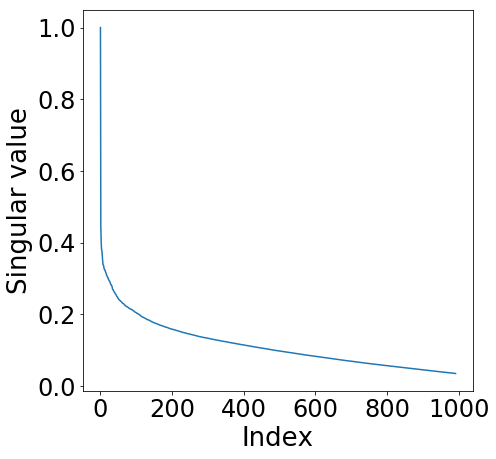

In [47]:
plt.figure(figsize=(7, 7))
plt.plot(singular_values / singular_values[0])
plt.xlabel('Index', fontsize=26)
plt.ylabel('Singular value', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
print('{} singular values are NaN'.format(np.isnan(singular_values).sum()))
print('{} singular values are less than 1e-12'.format(len(singular_values[singular_values < 1e-12])))

Variance preserved by first 500 components == 86.89%
Variance preserved by first 100 components == 41.30%
Variance preserved by first 5 components == 5.40%


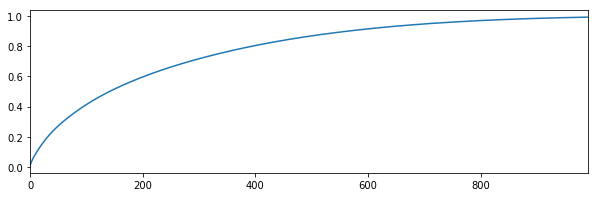

In [48]:
xtrans = np.dot(U, np.diag(singular_values))
explained_variance = np.var(xtrans, axis=0)
full_variance = np.array(np.mean(scaled_training_points.power(2), axis=0) - 
                         np.power(np.mean(scaled_training_points, axis=0), 2))
explained_variance_share = explained_variance / full_variance.sum()
ax = pd.Series(explained_variance_share.cumsum()).plot(kind='line', figsize=(10, 3))
print('Variance preserved by first 500 components == {:.2%}'.format(explained_variance_share.cumsum()[500]))
print('Variance preserved by first 100 components == {:.2%}'.format(explained_variance_share.cumsum()[100]))
print('Variance preserved by first 5 components == {:.2%}'.format(explained_variance_share.cumsum()[5]))

## Используем усечённое сингулярное разложение для снижения размерности данных

In [0]:
from sklearn.decomposition import TruncatedSVD

In [0]:
number_of_components = 100
svd = TruncatedSVD(n_components=number_of_components)
svd_fit = svd.fit(scaled_training_points)
transformed_training_points = svd.fit_transform(scaled_training_points) 
transformed_test_points = svd.transform(scaled_test_points) 

In [51]:
classifier = linear_model.LogisticRegression(C=1e5)
classifier.fit(transformed_training_points, newsgroups_training.target)

training_predictions = classifier.predict(transformed_training_points)
test_predictions = classifier.predict(transformed_test_points)
print('Training F1 score: %.4f' % f1_score(newsgroups_training.target, training_predictions, average='macro'))
print('Test F1 score: %.4f' % f1_score(newsgroups_test.target, test_predictions, average='macro'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training F1 score: 0.9808
Test F1 score: 0.8094


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### We can obtain model of similar quality using smaller number of features

In [0]:
number_of_components = 5
svd = TruncatedSVD(n_components=number_of_components)
svd_fit = svd.fit(scaled_training_points)
transformed_training_points = svd.fit_transform(scaled_training_points) 
transformed_test_points = svd.transform(scaled_test_points) 

In [0]:
training_dataframe = pd.DataFrame(transformed_training_points)
training_dataframe['target'] = newsgroups_training.target
training_dataframe['target'] = training_dataframe['target'].apply(lambda x: selected_categories[x])

In [54]:
training_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034 entries, 0 to 2033
Data columns (total 6 columns):
0         2034 non-null float64
1         2034 non-null float64
2         2034 non-null float64
3         2034 non-null float64
4         2034 non-null float64
target    2034 non-null object
dtypes: float64(5), object(1)
memory usage: 95.4+ KB


In [55]:
training_dataframe.shape

(2034, 6)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


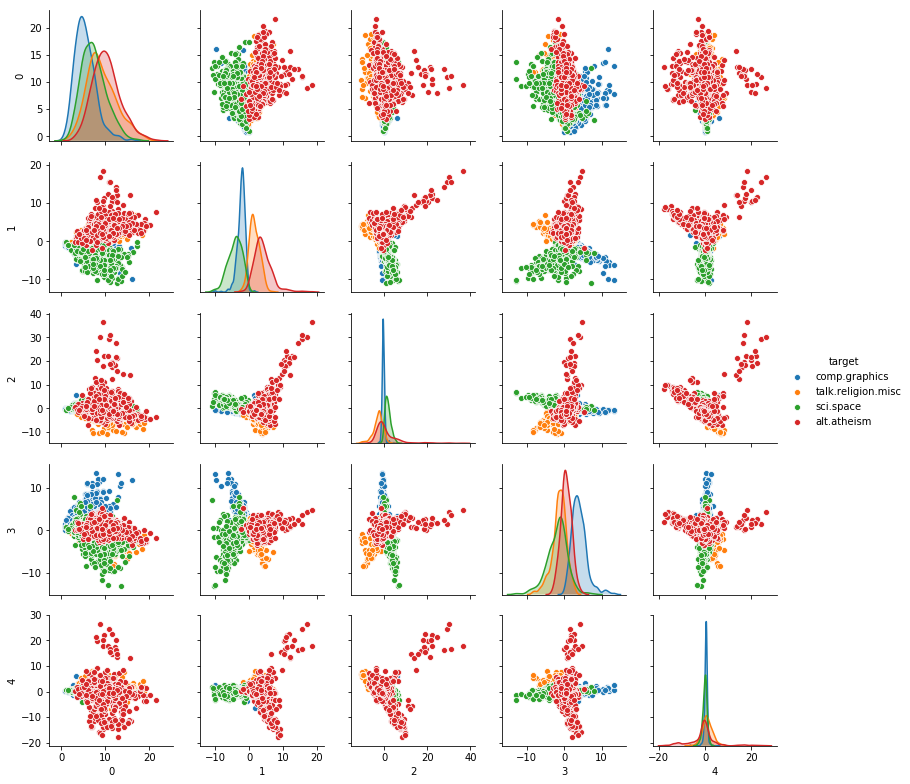

In [56]:
sns.pairplot(training_dataframe, hue='target', size=2.2)

Note, that the computational complexity for ```scikit-learn``` approach is $O(n^2)$. 
This computational complexity is prohibitive.
More effective realization based on Barnse-Hut with complexity $O(n \log(n))$.

## t-SNE complexity

t-SNE requires more computational resources, so we use data compressed with PCA 

In [0]:
training_dataframe = pd.DataFrame(transformed_training_points)
tsne = TSNE(n_components=2, random_state=0)

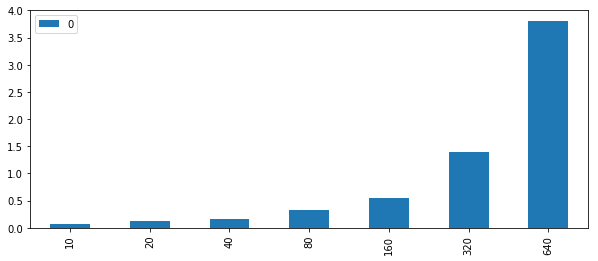

In [58]:
sample_size_list = [10, 20, 40, 80, 160, 320, 640]
run_time = np.empty((len(sample_size_list), 1))

for index, rows in enumerate(sample_size_list):
    start_time = time()
    Z = tsne.fit_transform(training_dataframe.iloc[:rows, :])
    run_time[index] = time() - start_time

pd.DataFrame(run_time, index=sample_size_list).plot(kind='bar', logy=False, figsize=(10, 4));

## Computation of t-SNE

In [0]:
tsne_training_data = tsne.fit_transform(training_dataframe)
tsne_training_dataframe = pd.DataFrame(tsne_training_data, columns=['x', 'y'])

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


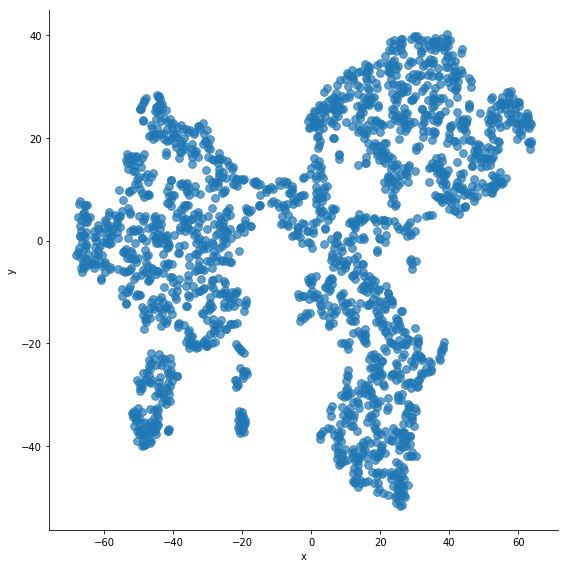

In [60]:
sns.lmplot('x', 'y', tsne_training_dataframe, fit_reg=False, size=8, scatter_kws={'alpha' : 0.7, 's' : 60})

In [0]:
tsne_training_dataframe['target'] = newsgroups_training.target
tsne_training_dataframe['target'] = tsne_training_dataframe['target'].apply(lambda x: selected_categories[x])

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Scatterplot of a 5D dataset reduced to 2D using t-SNE')

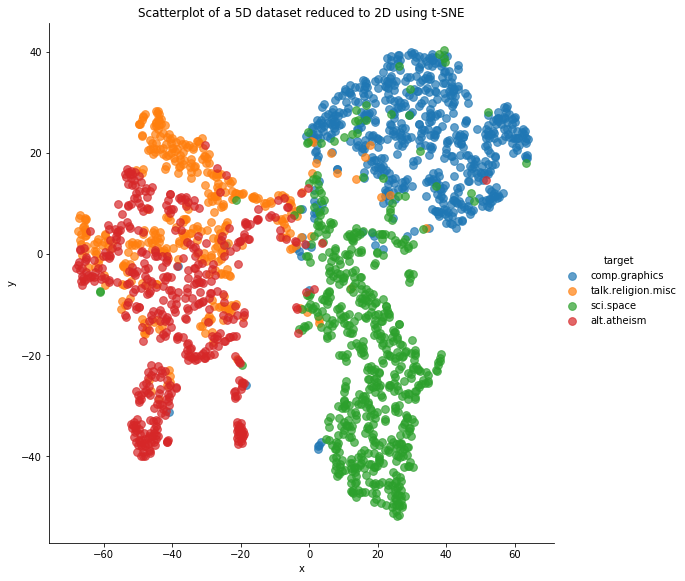

In [62]:
g = sns.lmplot('x', 'y', tsne_training_dataframe, hue='target', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a 5D dataset reduced to 2D using t-SNE')

In [0]:
test_dataframe = pd.DataFrame(transformed_test_points)
tsne_test_data = tsne.fit_transform(test_dataframe)
tsne_test_dataframe = pd.DataFrame(tsne_test_data, columns=['x', 'y'])
tsne_test_dataframe['target'] = newsgroups_test.target
tsne_test_dataframe['target'] = tsne_test_dataframe['target'].apply(lambda x: selected_categories[x])

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Scatterplot of a 5D dataset reduced to 2D using t-SNE')

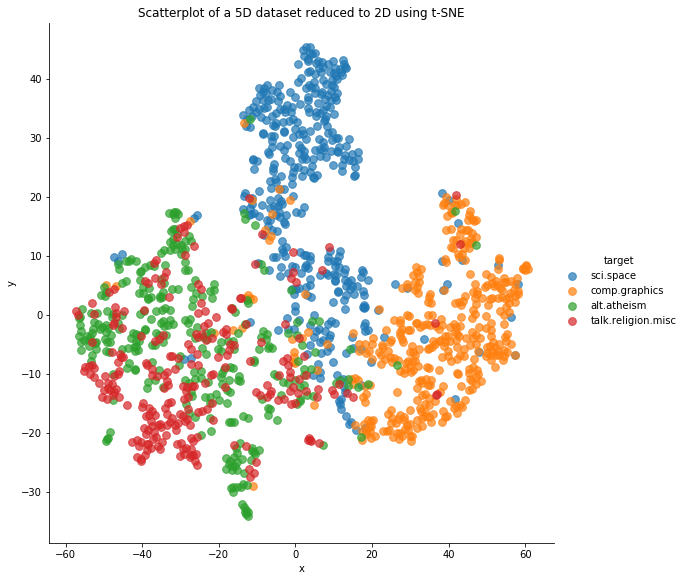

In [64]:
g = sns.lmplot('x', 'y', tsne_test_dataframe, hue='target', fit_reg=False, size=8,
                scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a 5D dataset reduced to 2D using t-SNE')

In [0]:
tsne_training_dataframe.to_csv('tsne_result_training_part.csv')
tsne_test_dataframe.to_csv('tsne_result_test_part.csv')